In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.signal as sig
import matplotlib.pyplot as plt
import peakutils as pkuts
from scipy import fftpack
from scipy.interpolate import interp1d
from matplotlib.offsetbox import AnchoredOffsetbox
import datetime as datetime
from datetime import datetime, timedelta
import os
import ctypes
import matplotlib.pyplot as plt

In [2]:
def rescale_counter(dat):
    new_counter = pd.factorize(dat.Packet)[0] + 1
    return new_counter

In [3]:
file = '08242023_test5.txt'
dat = pd.read_csv(file, dtype = str, delimiter = '|', names = ['Time','MISC','Packet','Message','RSSI'])
dat = dat[~dat.RSSI.str.contains('error')]
dat = dat[dat.MISC.str.contains('e')]
dat = dat.reset_index(drop=True)
dat_col = dat.Message
dat_col = dat_col.str.strip()
hexdat = dat_col.str.split(' ')

In [6]:
hexdat

0        [f8, 43, 08, 97, 41, a1, 00, 02, 00, 00, ff, dc]
1        [f8, 43, 08, 97, 41, a1, 00, 02, 00, 00, ff, dc]
2        [d2, 1e, 2d, 2f, 40, d5, ff, fe, ff, fb, ff, 73]
3        [d2, 1e, 2d, 2f, 40, d5, ff, fe, ff, fb, ff, 73]
4        [dc, 0c, 0c, 1e, 40, ad, ff, fe, ff, fb, ff, 73]
                               ...                       
15302    [fe, 65, fe, 6c, 41, 1c, ff, ff, 00, 00, ff, f8]
15303    [fe, 66, fe, 70, 41, 07, ff, ff, 00, 00, ff, f8]
15304    [fe, 66, fe, 70, 41, 07, ff, ff, 00, 00, ff, f8]
15305    [fe, 81, fe, 79, 41, 17, ff, ff, 00, 02, ff, f7]
15306    [fe, 81, fe, 79, 41, 17, ff, ff, 00, 02, ff, f7]
Name: Message, Length: 15307, dtype: object

In [4]:
serieslist = []

for k, ele in enumerate(hexdat): # k: count; ele: item
        if len(ele) == 12: # Only select those that have the correct length
            vlist=[]
            for i in range(0, 6):
                n = i*2 + 2
                value = ''.join(['0x', ele[n-2], ele[n-1]])
                hvalue = int(value, 16)
                convert_value = ctypes.c_int16(hvalue).value
                if i <= 2:
                    vlist.append(round(float(convert_value)*0.061/1000, 2))
                else:
                    vlist.append(round(float(convert_value)*35/1000, 2))
        else:
            #print('Line Error!'+str(k))
            #print(ele)
            vlist = [] #add empty list on error
        serieslist.append(vlist)

In [5]:
serieslist

[[-0.12, 0.13, 1.02, 0.07, 0.0, -1.26],
 [-0.12, 0.13, 1.02, 0.07, 0.0, -1.26],
 [-0.72, 0.71, 1.01, -0.07, -0.17, -4.93],
 [-0.72, 0.71, 1.01, -0.07, -0.17, -4.93],
 [-0.56, 0.19, 1.01, -0.07, -0.17, -4.93],
 [-0.56, 0.19, 1.01, -0.07, -0.17, -4.93],
 [-0.56, 0.19, 1.01, -0.07, -0.17, -4.93],
 [-0.33, -0.19, 1.01, 0.73, 0.14, -46.27],
 [-0.33, -0.19, 1.01, 0.73, 0.14, -46.27],
 [-0.45, -0.17, 1.01, 0.73, 0.14, -46.27],
 [-0.45, -0.17, 1.01, 0.73, 0.14, -46.27],
 [-0.58, -0.14, 1.01, 0.98, 0.21, -47.84],
 [-0.58, -0.14, 1.01, 0.98, 0.21, -47.84],
 [-0.5, -0.2, 1.0, 0.98, 0.21, -47.84],
 [-0.5, -0.2, 1.0, 0.98, 0.21, -47.84],
 [-0.5, -0.2, 1.0, 0.98, 0.21, -47.84],
 [-0.42, -0.18, 1.01, 0.7, 0.14, -24.75],
 [-0.42, -0.18, 1.01, 0.7, 0.14, -24.75],
 [-0.48, -0.11, 1.0, 0.7, 0.14, -24.75],
 [-0.48, -0.11, 1.0, 0.7, 0.14, -24.75],
 [-0.45, -0.12, 1.01, 0.32, 0.1, -5.6],
 [-0.45, -0.12, 1.01, 0.32, 0.1, -5.6],
 [-0.36, -0.09, 1.01, 0.32, 0.1, -5.6],
 [-0.36, -0.09, 1.01, 0.32, 0.1, -5.6],
 

In [13]:
# get only the filename from the file path
_, filename = os.path.split(file)
date = filename.split('_')[0]
date = datetime.strptime(date, '%m%d%Y') #which takes in "MMDDYYYY" like only US people write date order
 # Convert "realtime" to datetime, adding the date
dat["Time"] =  dat["Time"].str.strip()
dat["Time"] = pd.to_datetime(dat["Time"], format='%H:%M:%S.%f')
dat["Time"] = dat["Time"].apply(lambda t: datetime.combine(date, t.time()))
# Check for date rollover and increment the date when necessary
dat["Time"] = dat["Time"].mask(dat["Time"].diff().dt.total_seconds() < 0, 
                                           dat["Time"] + timedelta(days=1))

In [14]:
dat["Packet"] = dat["Packet"].astype(int)
dat["Message"] = serieslist
dat[['XL_X', 'XL_Y', 'XL_Z', 'G_X', 'G_Y', 'G_Z']] = pd.DataFrame(dat.Message.tolist(), index= dat.index)

In [15]:
new_counter = [0]
new_counter = rescale_counter(dat)
abscounterseries = pd.Series(new_counter, name = "Counter")

start_time = dat["Time"].iloc[0]
tarray = pd.array((dat["Time"] - start_time).dt.total_seconds())
tseries = pd.Series(tarray, name = 'Timestamp')
dat = pd.concat((dat, abscounterseries, tseries), axis=1)

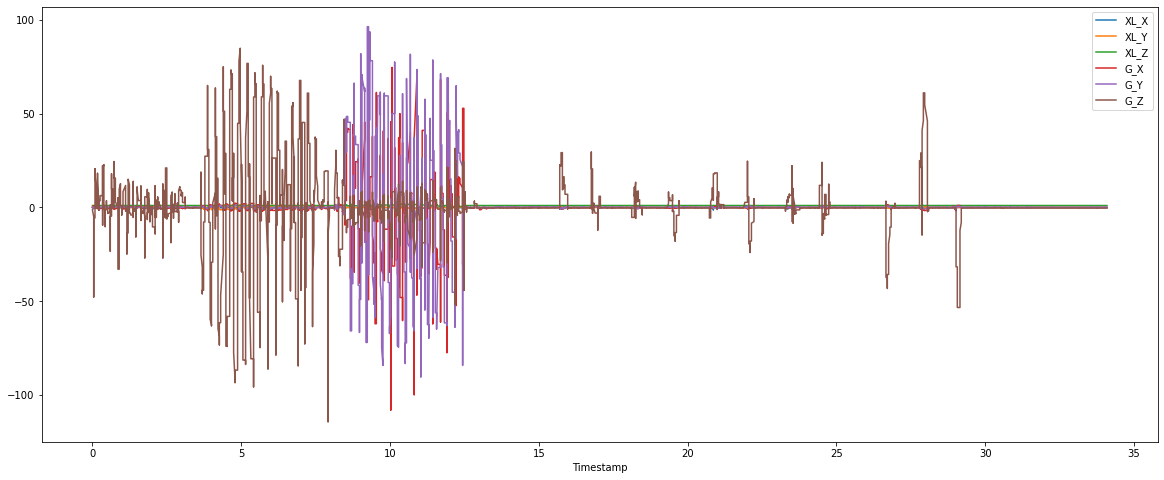

In [16]:
data_plot = pd.DataFrame(dat, columns=["Timestamp", "XL_X", "XL_Y", "XL_Z", "G_X", "G_Y", "G_Z"])
data_plot.plot(x="Timestamp", y=["XL_X", "XL_Y", "XL_Z", "G_X", "G_Y", "G_Z"], figsize=(20, 8))
plt.show()

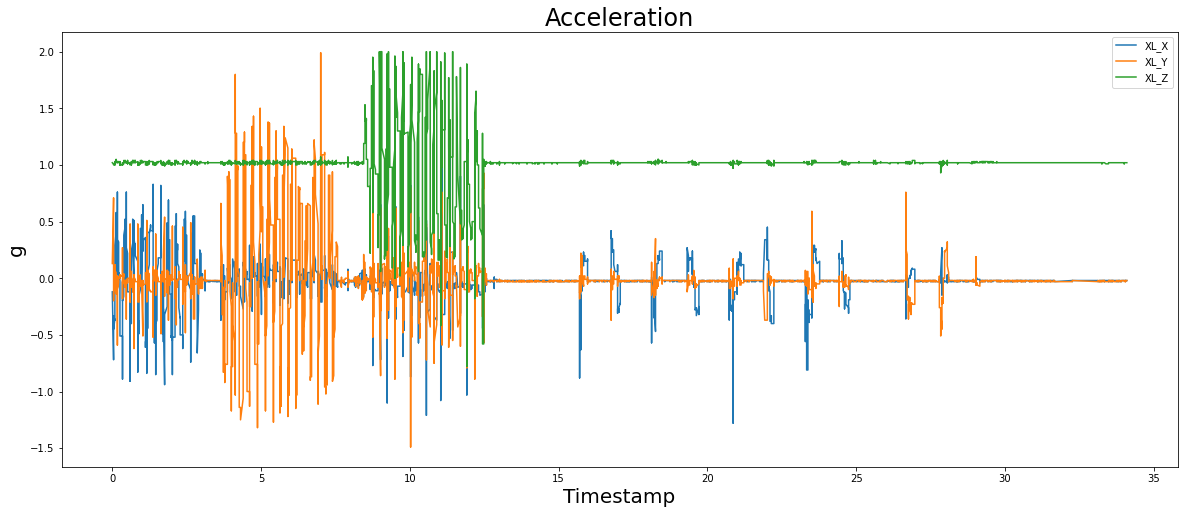

In [64]:
data_plot_XL = pd.DataFrame(dat, columns=["Timestamp", "XL_X", "XL_Y", "XL_Z"])
data_plot_XL.plot(x="Timestamp", y=["XL_X", "XL_Y", "XL_Z"], figsize=(20, 8))
plt.xlabel('Timestamp', fontsize="20")
plt.ylabel('g', fontsize="20")
plt.title("Acceleration", fontsize="24")
plt.show()

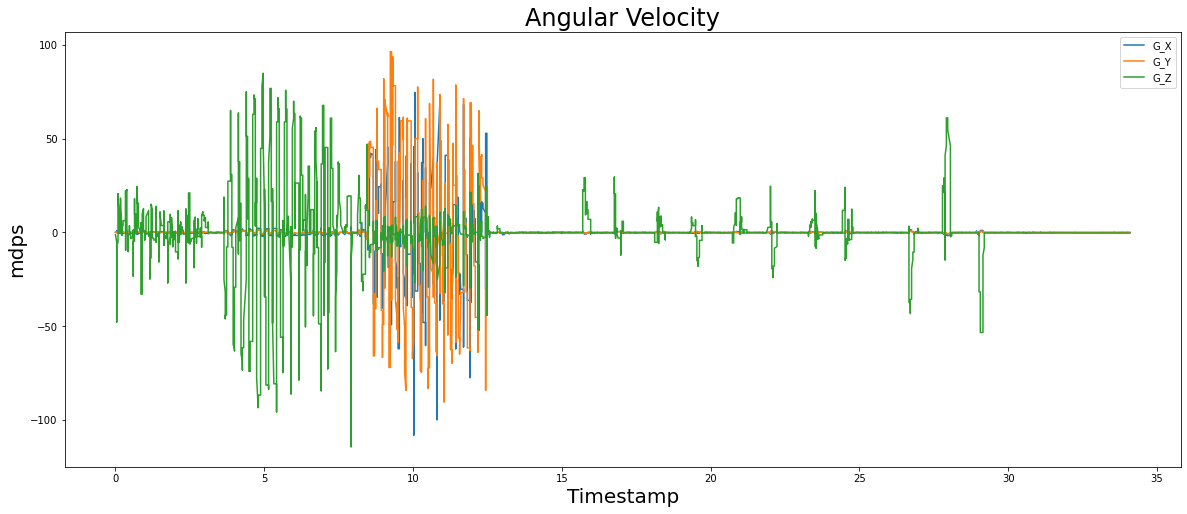

In [62]:
data_plot_G = pd.DataFrame(dat, columns=["Timestamp", "G_X", "G_Y", "G_Z"])
data_plot_G.plot(x="Timestamp", y=["G_X", "G_Y", "G_Z"], figsize=(20, 8))
plt.xlabel('Timestamp', fontsize="20")
plt.ylabel('mdps', fontsize="20")
plt.title("Angular Velocity", fontsize="24")
plt.show()

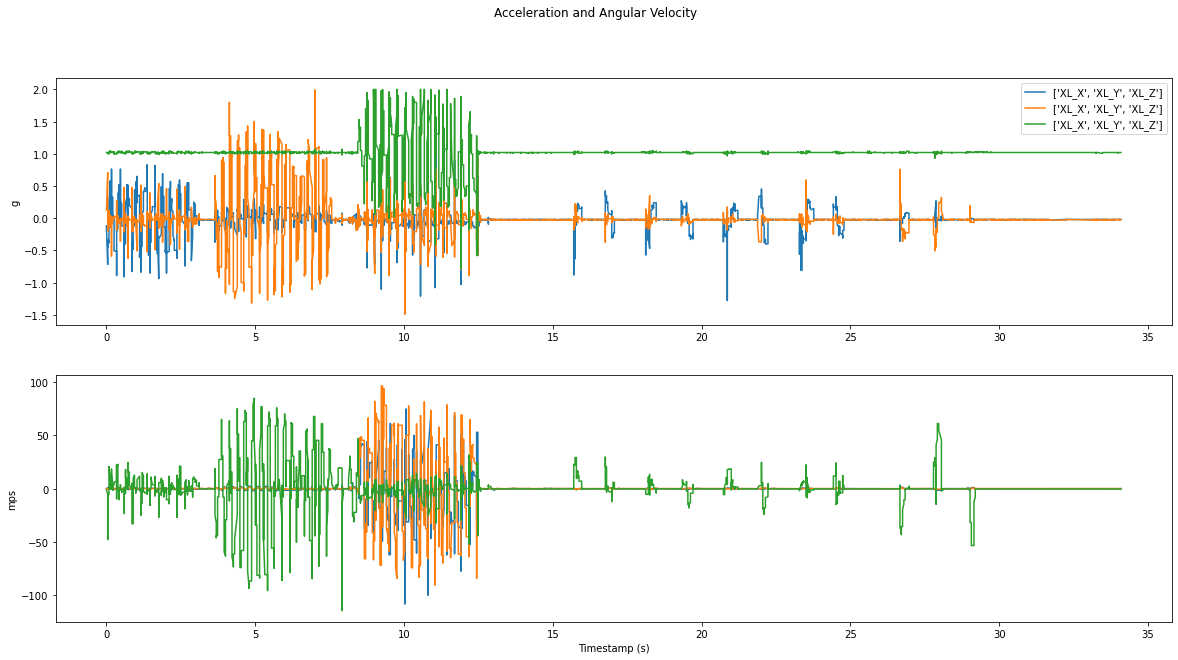

In [45]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10))
fig.suptitle('Acceleration and Angular Velocity')

ax1.plot(data_plot_XL["Timestamp"], data_plot_XL[["XL_X", "XL_Y", "XL_Z"]])
ax1.set_ylabel('g')

ax2.plot(data_plot_G["Timestamp"], data_plot_G[["G_X", "G_Y", "G_Z"]])
ax2.set_xlabel('Timestamp (s)')
ax2.set_ylabel('mps')

ax1.legend()
plt.show()